# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **model analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code from [lecture 5](https://numeconcopenhagen.netlify.com/lectures/Workflow_and_debugging).
> 1. Remember this [guide](https://www.markdownguide.org/basic-syntax/) on markdown and (a bit of) latex.
> 1. Turn on automatic numbering by clicking on the small icon on top of the table of contents in the left sidebar.
> 1. The `modelproject.py` file includes a function which could be used multiple times in this notebook.

Imports and set magics:

In [16]:
import numpy as np
from scipy import optimize
import sympy as sm
import matplotlib.pyplot as plt

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2
#XD FOR SMART UPLOAD
# local modules
import modelproject

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model description



We consider a Solow-model that incorporates fossil fuels and climate externalities 

 The model structure is 

1 $$Y_t=D_tK^\alpha _t(A_tL_t)^{\beta}E^{\epsilon}_t,\text{   }\alpha, \beta, \varepsilon \geq0, \alpha+\beta+\varepsilon=1$$

2 $$ K_{t+1}=sY_t+(1-\delta) K_t, \text{  } 0<\delta<1 $$

3 $$L_{t+1}=(1+n)L_t, \text{   } n\geq 0$$

4 $$A_{t+1}=(1+g)A_t, \text{   } g\geq 0$$

5 $$ R_{t+1}=R_t-E_t$$

6 $$ E_t=s_ER_t, \text{   } 0<s_E<\delta $$

7 $$ D_t=\left(\frac{R_t}{R_0}\right)^{\phi},\text{   }\phi\geq 0$$






* $K_t$ is capital
* $L_t$ is labor (growing with a constant rate of $n$)
* $E_t$ is "Oil" (where the amount used in each period is a fraction of the remaining reserve)
* $R_t$ is the remaining reserve of oil, $R_0$ is the initial reserve 
* $A_t$ is technology (growing with a constant rate of $g$)
* $D_t$ is the damage function
* $Y_t$ is GDP





Using the above equations, the following transition curve can be found 

$$z_{t+1} =\left(\frac{1}{1-s_E}\right)^{\varepsilon+\phi}\left(\frac{1}{(1+n)(1+g)}\right)^\beta (s+(1-\delta)z_t)^{1-\alpha})z_t^\alpha$$

where $z_t$ is the capital/output ratio $z_t=\frac{K}{Y}$
 

In [5]:
# First we consider the Solow model without climate externalities, that is we reduce the model to a Solow model extended with oil only, which is equal to setting phi to zero
# Parameters: 
epsilon = 0.1
beta = 0.6
alpha = 0.3
phi = 0 
delta =0.05
n = 0.01
g = 0.02
s =0.20
se = 0.005

In [6]:
# The condition for steady state, that is z(t) = z(t+1), is rewritten to give the following
obj_zss = lambda z: z- (1/(1-se))**(epsilon+phi)*((1/((1+n)*(1+g)))**beta)*((s+(1-delta)*z)**(1-alpha))*z**alpha

In [38]:
# Now we optimize using the "brentq" method 
Interval = [0.1,100]# An interval in which we expect to find the steady state, defined in a way so that we aviod the trivial steady state 

result = optimize.root_scalar(obj_zss,bracket=Interval,method="brentq")
print(f'The steady state for z is: z* = {result.root:.3f}')

The steady state for z is: z* = 3.227


In [21]:
# Now we introduce climate change in the form of the damage function, but allowing phi to take on various values 
phis=[0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,1.8]


SS_list =[]
for phi in phis: # Obtaining various SS values for z by changing phi 
    result = optimize.root_scalar(obj_zss,bracket=Interval,method="brentq")
    SS_list.append(result.root)

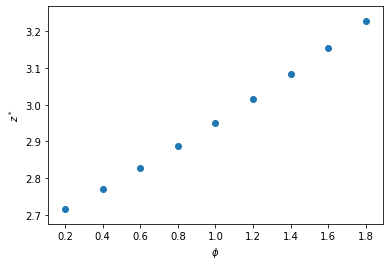

In [31]:
#Plotting relationship between steady state and phi
fig=plt.figure()
ax = fig.add_subplot(1,1,1)
cs = plt.scatter(phis,SS_list)
ax.set_xlabel('$\phi$')
ax.set_ylabel('$z^*$');

## Analytical solution

To solve the above model we use sympy 

In [194]:
#Variables are defined 
k = sm.symbols('k')
alpha = sm.symbols('alpha',positive =True)
delta = sm.symbols('delta',positive =True)
sigma = sm.symbols('sigma',positive =True)
s = sm.symbols('s',positive =True)
g = sm.symbols('g')
n = sm.symbols('n')



In [195]:
objective = (1/((1+g)*(1+n)))*(s*((alpha*k**((sigma-1)/sigma))+(1-alpha))**((sigma/(sigma-1)))+(1-delta)*k)

In [196]:
 
ss = sm.Eq(objective,k)
ss

Eq((k*(1 - delta) + s*(alpha*k**((sigma - 1)/sigma) - alpha + 1)**(sigma/(sigma - 1)))/((g + 1)*(n + 1)), k)

In [197]:
#Now we solve for k_tilde 
kss = sm.solve([sigma>0,alpha>0,delta>0,s>0],ss,k)
kss

TypeError: cannot determine truth value of Relational

In [169]:
ss = sm.Eq(k,(s*k**alpha+(1-delta)*k)/((1+n)*(1+g)))

and **solve** it

In [170]:
kss = sm.solve(ss,k)[0]
kss

((delta + g*n + g + n)/s)**(1/(alpha - 1))

For later use, we turn the solution into a **Python funciton**

In [5]:
ss_func = sm.lambdify((s,g,n,alpha,delta),kss)

## Numerical solution

We can re-write the equation for the steady state capital per capita as

\\[ 0 = \frac{1}{(1+n)(1+g)}[sf(\tilde{k}^{\ast})+(1-\delta)\tilde{k}^{\ast}] - \tilde{k}^{\ast} \\]

whereby it clearly becomes a **root-finding problem**. Such a problem can be solved by a **bisection method**.

Define the model **parameters**:

In [6]:
s = 0.2
g = 0.02
n = 0.01
alpha = 1/3
delta = 0.1

**Solve numerically** for the steady state:

In [7]:
solution = modelproject.solve_for_ss(s,g,n,alpha,delta)

print(f'analytical solution is: {ss_func(s,g,n,alpha,delta):.3f}')
print(f' numerical solution is: {solution.root:.3f}')

analytical solution is: 1.904
 numerical solution is: 1.904


# Further analysis

ADD FURTHER ANALYSIS, VISUALIZATIONS AND EXTENSIONS.

# Conclusion

ADD CONCISE CONCLUSION.